In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')
spec = "human"
ST_name = "melanoma5fold"
seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
spa_adata = sc.read_h5ad("../../data/ST/melanoma/spatial.h5ad")
pd.DataFrame(spa_adata.obsm['spatial'], index=spa_adata.obs_names, columns=['x','y']).to_csv(f"../../output/locations/{ST_name}.csv", index=False)
spa_adata = spa_adata[:, (spa_adata.var_names.values != 'MARCH1') & (spa_adata.var_names.values != 'MARCH2')].copy()
rna_adata = sc.read_h5ad("../../data/scRNAseq/melanoma/Tirosh_raw.h5ad")
rna_adata = rna_adata[:, (rna_adata.var_names.values != 'MARCH1') & (rna_adata.var_names.values != 'MARCH2')].copy()

In [3]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, coord_type="grid", n_neighs=4)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
sc.pp.filter_genes(rna_adata, min_cells=10)
sc.pp.highly_variable_genes(spa_adata, n_top_genes=5000)
# rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sdm.extract_lr(spa_adata, spec, min_cell=0)
spa_genes = set()
for pair in spa_adata.uns['geneInter'].interaction_name:
    _genes = pair.split('_')
    for g in _genes:
        for _g in g.split(":"):
            spa_genes.add(_g)
for gene in spa_adata.uns['moranI'].index[spa_adata.uns['moranI'].I >= 0].values:
    spa_genes.add(gene)
    
for gene in spa_adata.var_names[spa_adata.var.highly_variable]:
    spa_genes.add(gene)
    
print(len(np.intersect1d(list(spa_genes), spa_adata.var_names)), len(spa_genes), spa_adata.n_vars)
spa_adata = spa_adata[:, np.intersect1d(list(spa_genes), spa_adata.var_names)]
rna_adata, spa_adata

10350 10391 16146


(AnnData object with n_obs × n_vars = 4645 × 21118
     obs: 'celltype', 'malignant', 'leiden'
     var: 'n_cells',
 View of AnnData object with n_obs × n_vars = 293 × 10350
     obs: 'B', 'CAF', 'Endo', 'Macro', 'Melanoma or unclassified', 'NK', 'T'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial_neighbors', 'moranI', 'hvg', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [4]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((293, 10350), (4645, 21118), (9758,))

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        clip_max=1,
        mapping_lowdim=128,
        n_epochs=2000,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

    df_transImpCls[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

    df_transImp[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                mapping_lowdim=128,
                n_epochs=2000,
                clip_max=1,
                seed=seed,
                device=device)
    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "164894613", top_k=2000, verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImp_res), "(TransImp)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
      )


===== Fold 1 =====
Number of train genes: 7806, Number of test genes: 1952


[TransImp] Epoch: 2000/2000, loss: 0.980859, (IMP) 0.978188, (SPA) 1.0 x 0.002671: 100%|██████████| 2000/2000 [00:11<00:00, 180.60it/s]


Median correlation: 0.1757241763921376 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.963770, (IMP) 0.963770, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 413.77it/s]


Median correlation: 0.20438896288680336 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.970326, (IMP) 0.970326, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 263.58it/s]


Median correlation: 0.20912629655999987 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.975238, (IMP) 0.970620, (SPA) 1.0 x 0.004618: 100%|██████████| 2000/2000 [00:07<00:00, 266.41it/s]


Median correlation: 0.17586469577489572 (TransImpClsSpa)
			0.12555670732940616 (stPlus)
			0.17669236723362253 (spaGE)


INFO:root:7806 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:7806 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 7806 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.333, KL reg: 0.074
Score: 0.381, KL reg: 0.000
Score: 0.382, KL reg: 0.000
Score: 0.382, KL reg: 0.000
Score: 0.382, KL reg: 0.000
Score: 0.382, KL reg: 0.000
Score: 0.382, KL reg: 0.000
Score: 0.382, KL reg: 0.000
Score: 0.382, KL reg: 0.000
Score: 0.382, KL reg: 0.000


INFO:root:Saving results..


			0.2078861963126153 (Tangram)

===== Fold 2 =====
Number of train genes: 7806, Number of test genes: 1952


[TransImp] Epoch: 2000/2000, loss: 0.970784, (IMP) 0.968152, (SPA) 1.0 x 0.002632: 100%|██████████| 2000/2000 [00:10<00:00, 199.10it/s]


Median correlation: 0.16900167581062986 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.954143, (IMP) 0.954143, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 424.48it/s]


Median correlation: 0.1941102647710679 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.960082, (IMP) 0.960082, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 269.94it/s]


Median correlation: 0.19825883309824277 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.965172, (IMP) 0.960700, (SPA) 1.0 x 0.004472: 100%|██████████| 2000/2000 [00:07<00:00, 277.09it/s]


Median correlation: 0.1689995182749118 (TransImpClsSpa)
			nan (stPlus)
			0.1612757385741842 (spaGE)


INFO:root:7806 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:7806 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 7806 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.336, KL reg: 0.074
Score: 0.384, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000


INFO:root:Saving results..


Score: 0.385, KL reg: 0.000
			0.20159298799180386 (Tangram)

===== Fold 3 =====
Number of train genes: 7806, Number of test genes: 1952


[TransImp] Epoch: 2000/2000, loss: 0.977445, (IMP) 0.974882, (SPA) 1.0 x 0.002563: 100%|██████████| 2000/2000 [00:09<00:00, 201.86it/s]


Median correlation: 0.17220867816231572 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.960214, (IMP) 0.960214, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 425.86it/s]


Median correlation: 0.1912625606083242 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.967080, (IMP) 0.967080, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 271.15it/s]


Median correlation: 0.2016585856431285 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.971471, (IMP) 0.967017, (SPA) 1.0 x 0.004454: 100%|██████████| 2000/2000 [00:07<00:00, 274.65it/s]


Median correlation: 0.16771735557444312 (TransImpClsSpa)
			nan (stPlus)
			0.1637540829054059 (spaGE)


INFO:root:7806 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:7806 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 7806 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.336, KL reg: 0.074
Score: 0.383, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000


INFO:root:Saving results..


Score: 0.385, KL reg: 0.000
			0.2002529714212375 (Tangram)

===== Fold 4 =====
Number of train genes: 7807, Number of test genes: 1951


[TransImp] Epoch: 2000/2000, loss: 0.965833, (IMP) 0.963218, (SPA) 1.0 x 0.002616: 100%|██████████| 2000/2000 [00:12<00:00, 161.97it/s]


Median correlation: 0.16712065402558585 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.949243, (IMP) 0.949243, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:05<00:00, 398.44it/s]


Median correlation: 0.193916538647332 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.955307, (IMP) 0.955307, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:08<00:00, 236.03it/s]


Median correlation: 0.19858821579820782 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.960359, (IMP) 0.955932, (SPA) 1.0 x 0.004427: 100%|██████████| 2000/2000 [00:09<00:00, 215.22it/s]


Median correlation: 0.1690580138115802 (TransImpClsSpa)
			nan (stPlus)
			0.16193048115191938 (spaGE)


INFO:root:7807 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:7807 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 7807 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.337, KL reg: 0.074
Score: 0.384, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.385, KL reg: 0.000
Score: 0.386, KL reg: 0.000
Score: 0.386, KL reg: 0.000
Score: 0.386, KL reg: 0.000
Score: 0.386, KL reg: 0.000
Score: 0.386, KL reg: 0.000


INFO:root:Saving results..


Score: 0.386, KL reg: 0.000
			0.19562977780973698 (Tangram)

===== Fold 5 =====
Number of train genes: 7807, Number of test genes: 1951


[TransImp] Epoch: 2000/2000, loss: 0.970330, (IMP) 0.967771, (SPA) 1.0 x 0.002558: 100%|██████████| 2000/2000 [00:09<00:00, 202.06it/s]


Median correlation: 0.16848591374968128 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.953952, (IMP) 0.953952, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 443.29it/s]


Median correlation: 0.19877511524417565 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.960130, (IMP) 0.960130, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 272.18it/s]


Median correlation: 0.20060606063091607 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.964980, (IMP) 0.960535, (SPA) 1.0 x 0.004445: 100%|██████████| 2000/2000 [00:07<00:00, 271.55it/s]


Median correlation: 0.17295080590631176 (TransImpClsSpa)
			0.10158563260643075 (stPlus)
			0.16795425184994023 (spaGE)


INFO:root:7807 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:7807 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 7807 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.336, KL reg: 0.074
Score: 0.383, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000
Score: 0.384, KL reg: 0.000


INFO:root:Saving results..


Score: 0.384, KL reg: 0.000
			0.2014110397200425 (Tangram)
0.17017132724105266 (TransImpSpa) 0.2017827347680774 (TransImp) 0.19658390293797118 (TransImpCls) 0.17093370334614572 (TransImpClsSpa) nan (stPlus) 0.1660893217552929 (spaGE) 0.20155721667238713 (Tangram)


In [6]:
df_transImp.to_csv(f'../../output/{ST_name}_{ST_name}_TransImp.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [7]:
dict_df = {
            "TransImp":df_transImp, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    genes=spa_adata.var_names,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


In [9]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImp: 0.288007
	True vs TransImpSpa: 0.005496
	True vs TransImpCls: 0.306599
	True vs TransImpClsSpa: 0.005104
	True vs spaGE: 0.179421
	True vs Tangram: 0.259559
	True vs truth: 0.000000


In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings

color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
methods = ['truth', 'Tangram', 'TransImp', 'TransImpSpa', 'spaGE', 'stPlus',  'TransImpCls', 'TransImpClsSpa']
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [15]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}, 'pval':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=4)
        sq.gr.spatial_autocorr(
            imp_adata,
            genes=imp_adata.var_names,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['pval'][method] = pd.Series(imp_adata.uns['moranI'].pval_norm, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

100%|██████████| 8/8 [00:33<00:00,  4.23s/it]


In [16]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr, df_pval

(         Tangram  TransImp  TransImpCls  TransImpClsSpa   TransImpSpa  \
 A1BG    0.000000  0.000000     0.000000        0.066387  3.250067e-12   
 A2M     0.000000  0.000000     0.000000        0.066387  1.906706e-10   
 A4GALT  0.000000  0.000000     0.000000        0.066387  9.249004e-08   
 AAAS    0.000000  0.000000     0.000000        0.066387  1.055500e-07   
 AACS    0.000000  0.000000     0.000000        0.066387  2.213413e-07   
 ...          ...       ...          ...             ...           ...   
 ZSWIM6  0.326569  0.377161     0.274275        0.129563  6.355444e-03   
 ZSWIM7  0.380358  0.435896     0.263743        0.128007  3.213839e-03   
 ZUFSP   0.451562  0.477025     0.256093        0.127025  1.775981e-03   
 ZWINT   0.471036  0.447454     0.174214        0.118240  1.730082e-03   
 ZYX     0.453932  0.439680     0.127639        0.097930  6.511522e-05   
 
            spaGE  stPlus         truth  
 A1BG    0.000000     NaN  4.825682e-01  
 A2M     0.000000     NaN 

(Tangram) Valid genes: 7059/9758
0
Tangram
(Tangram) Valid genes: 7059/9758, Ground Sig/Total (792/7059), Pred Sig/total (6998/7059)
FPR: 0.990745
(TransImp) Valid genes: 7059/9758
0
TransImp
(TransImp) Valid genes: 7059/9758, Ground Sig/Total (792/7059), Pred Sig/total (7036/7059)
FPR: 0.996490
(TransImpSpa) Valid genes: 7059/9758
0
TransImpSpa
(TransImpSpa) Valid genes: 7059/9758, Ground Sig/Total (792/7059), Pred Sig/total (246/7059)
FPR: 0.035743
(spaGE) Valid genes: 7059/9758
0
spaGE
(spaGE) Valid genes: 7059/9758, Ground Sig/Total (792/7059), Pred Sig/total (6615/7059)
FPR: 0.933940
(stPlus) Valid genes: 7034/9758
7034
stPlus
(stPlus) Valid genes: 7034/9758, Ground Sig/Total (788/7034), Pred Sig/total (0/7034)
FPR: 0.000000


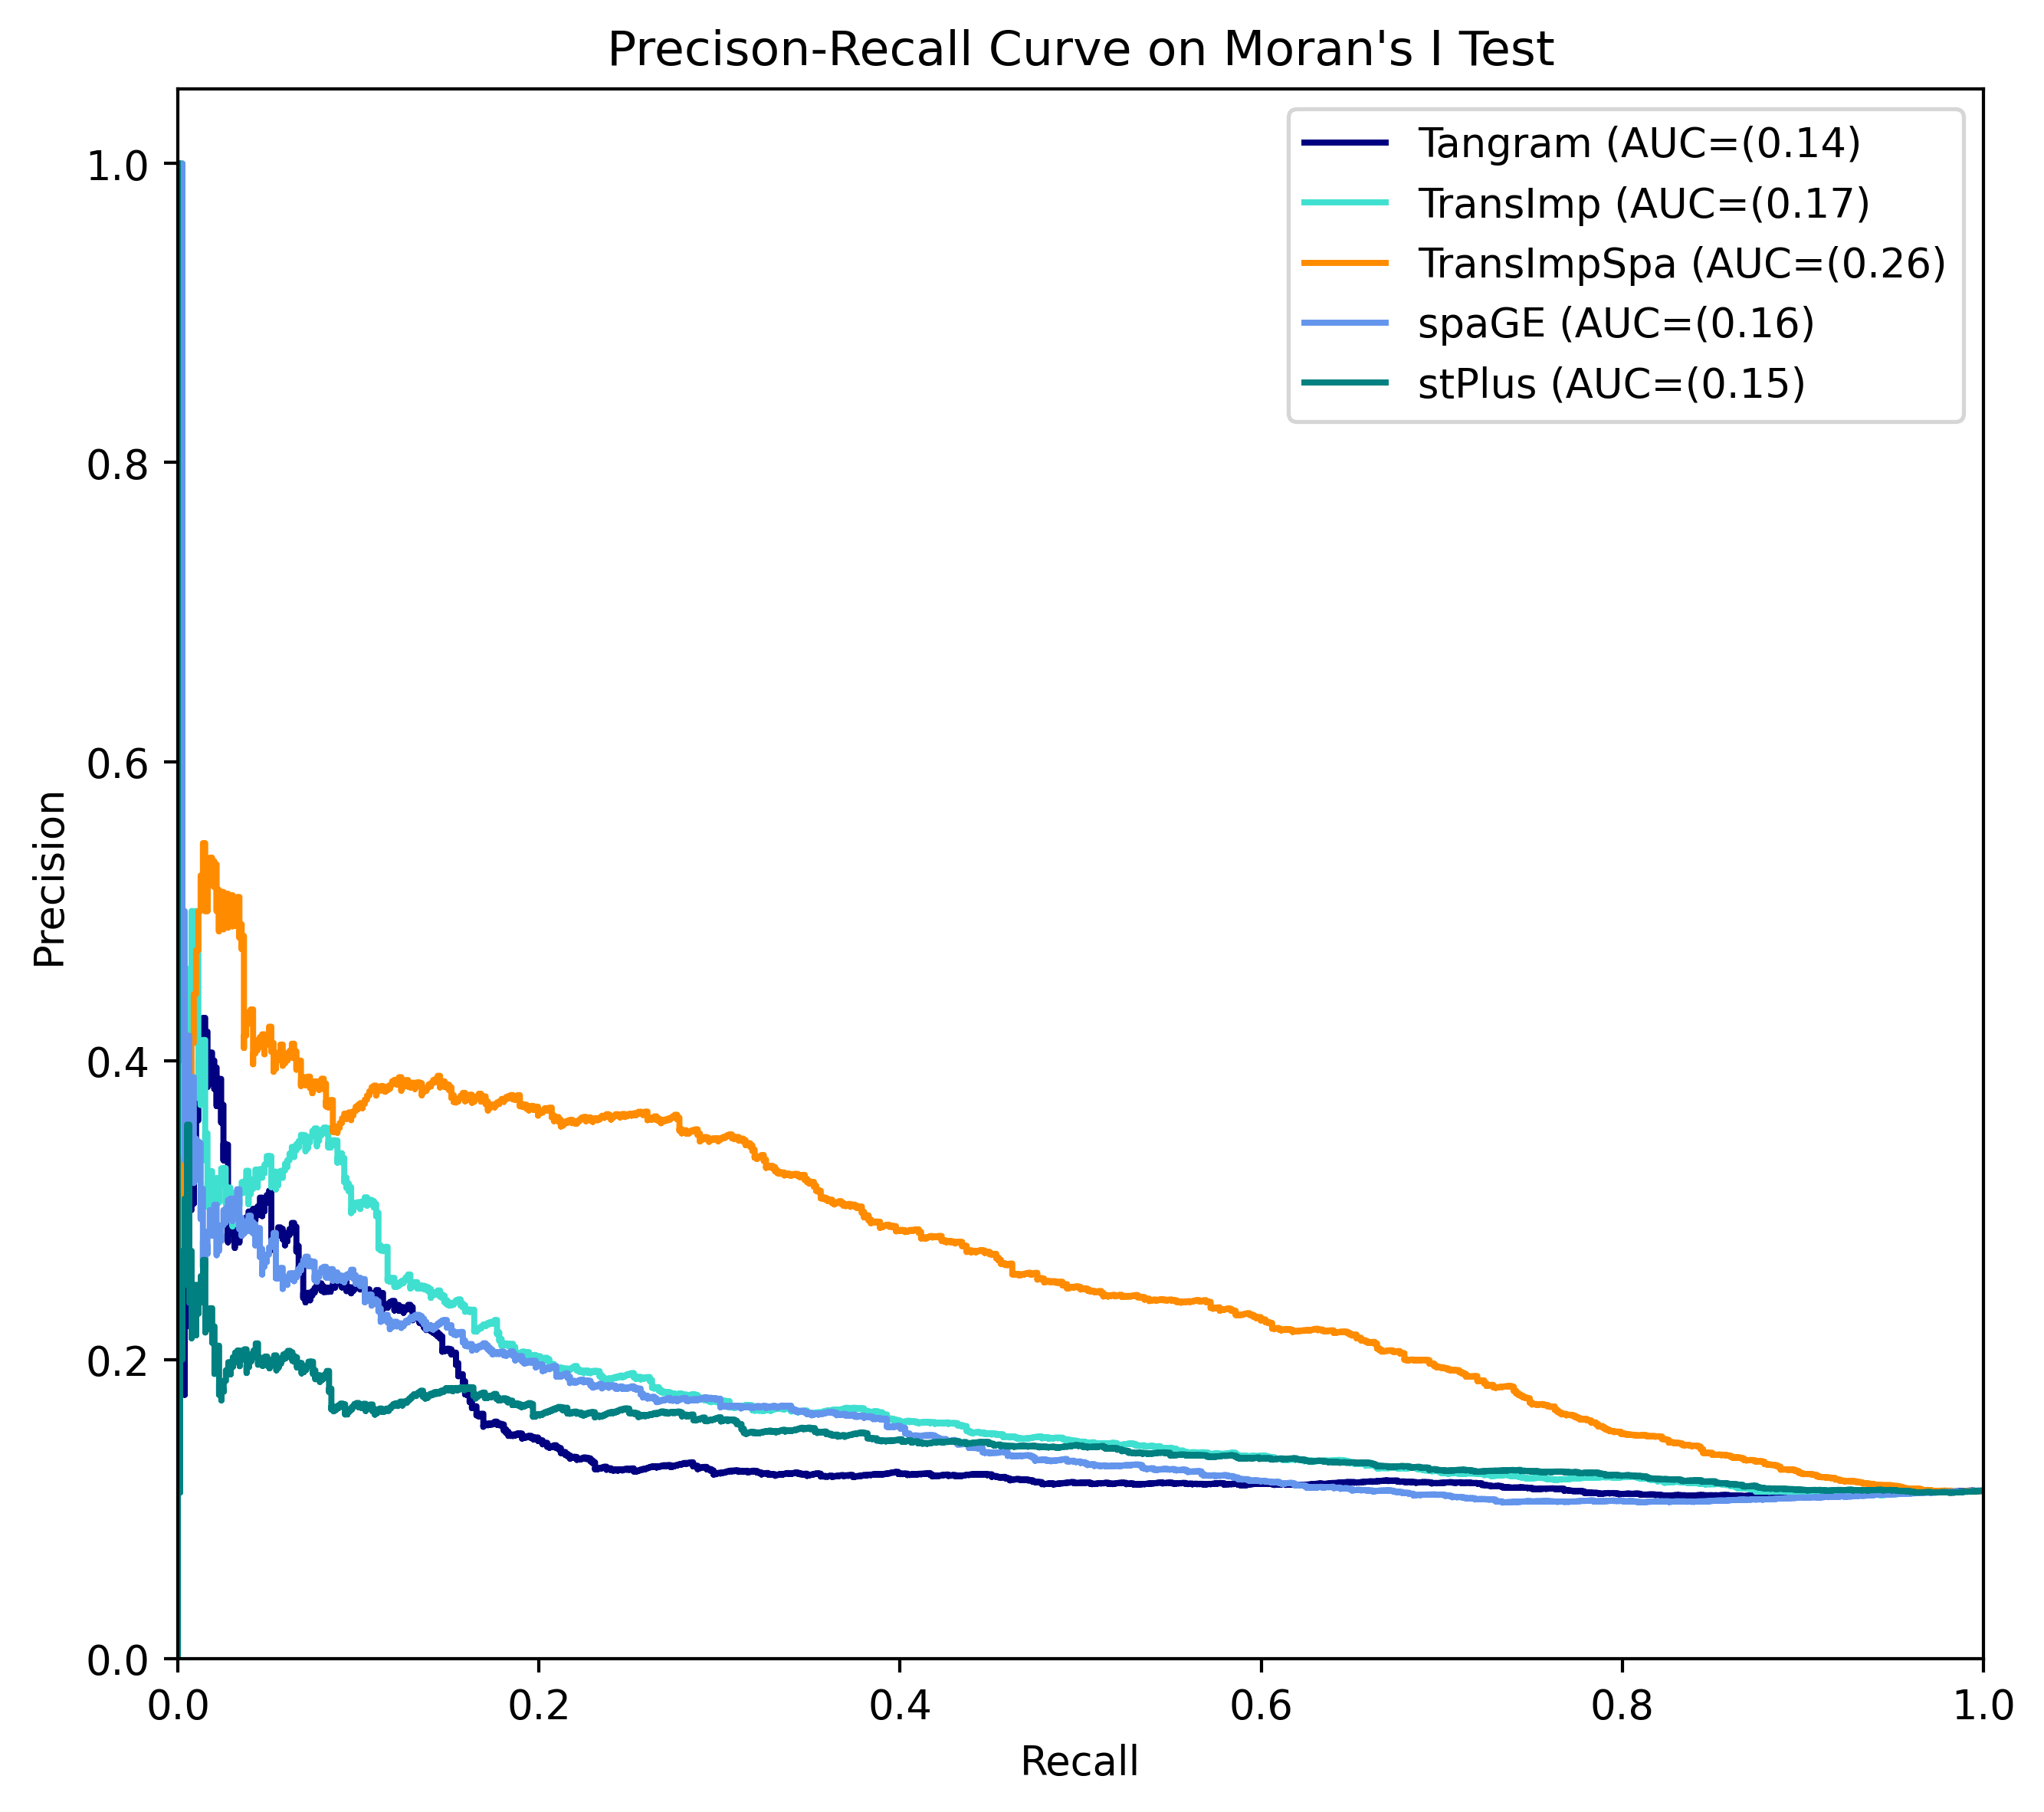

In [39]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, preds_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min()/1e6, 1e-300))
    score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(np.isnan(preds_pval).sum())
    # plt.hist(fdr, bins=100)
    print(method)
    preds = preds_pval < thred
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(truth_pval < thred).sum()}/{truth_pval.shape[0]}), Pred Sig/total ({(preds_pval < thred).sum()}/{preds_pval.shape[0]})')
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpClsSpa", 'truth'}:
        idx += 1
    else:
        continue     
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 7059/9758
Tangram
FPR: 0.990745
(TransImp) Valid genes: 7059/9758
TransImp
FPR: 0.996490
(TransImpSpa) Valid genes: 7059/9758
TransImpSpa
FPR: 0.035743
(spaGE) Valid genes: 7059/9758
spaGE
FPR: 0.933940
(stPlus) Valid genes: 7034/9758
stPlus
FPR: 0.000000


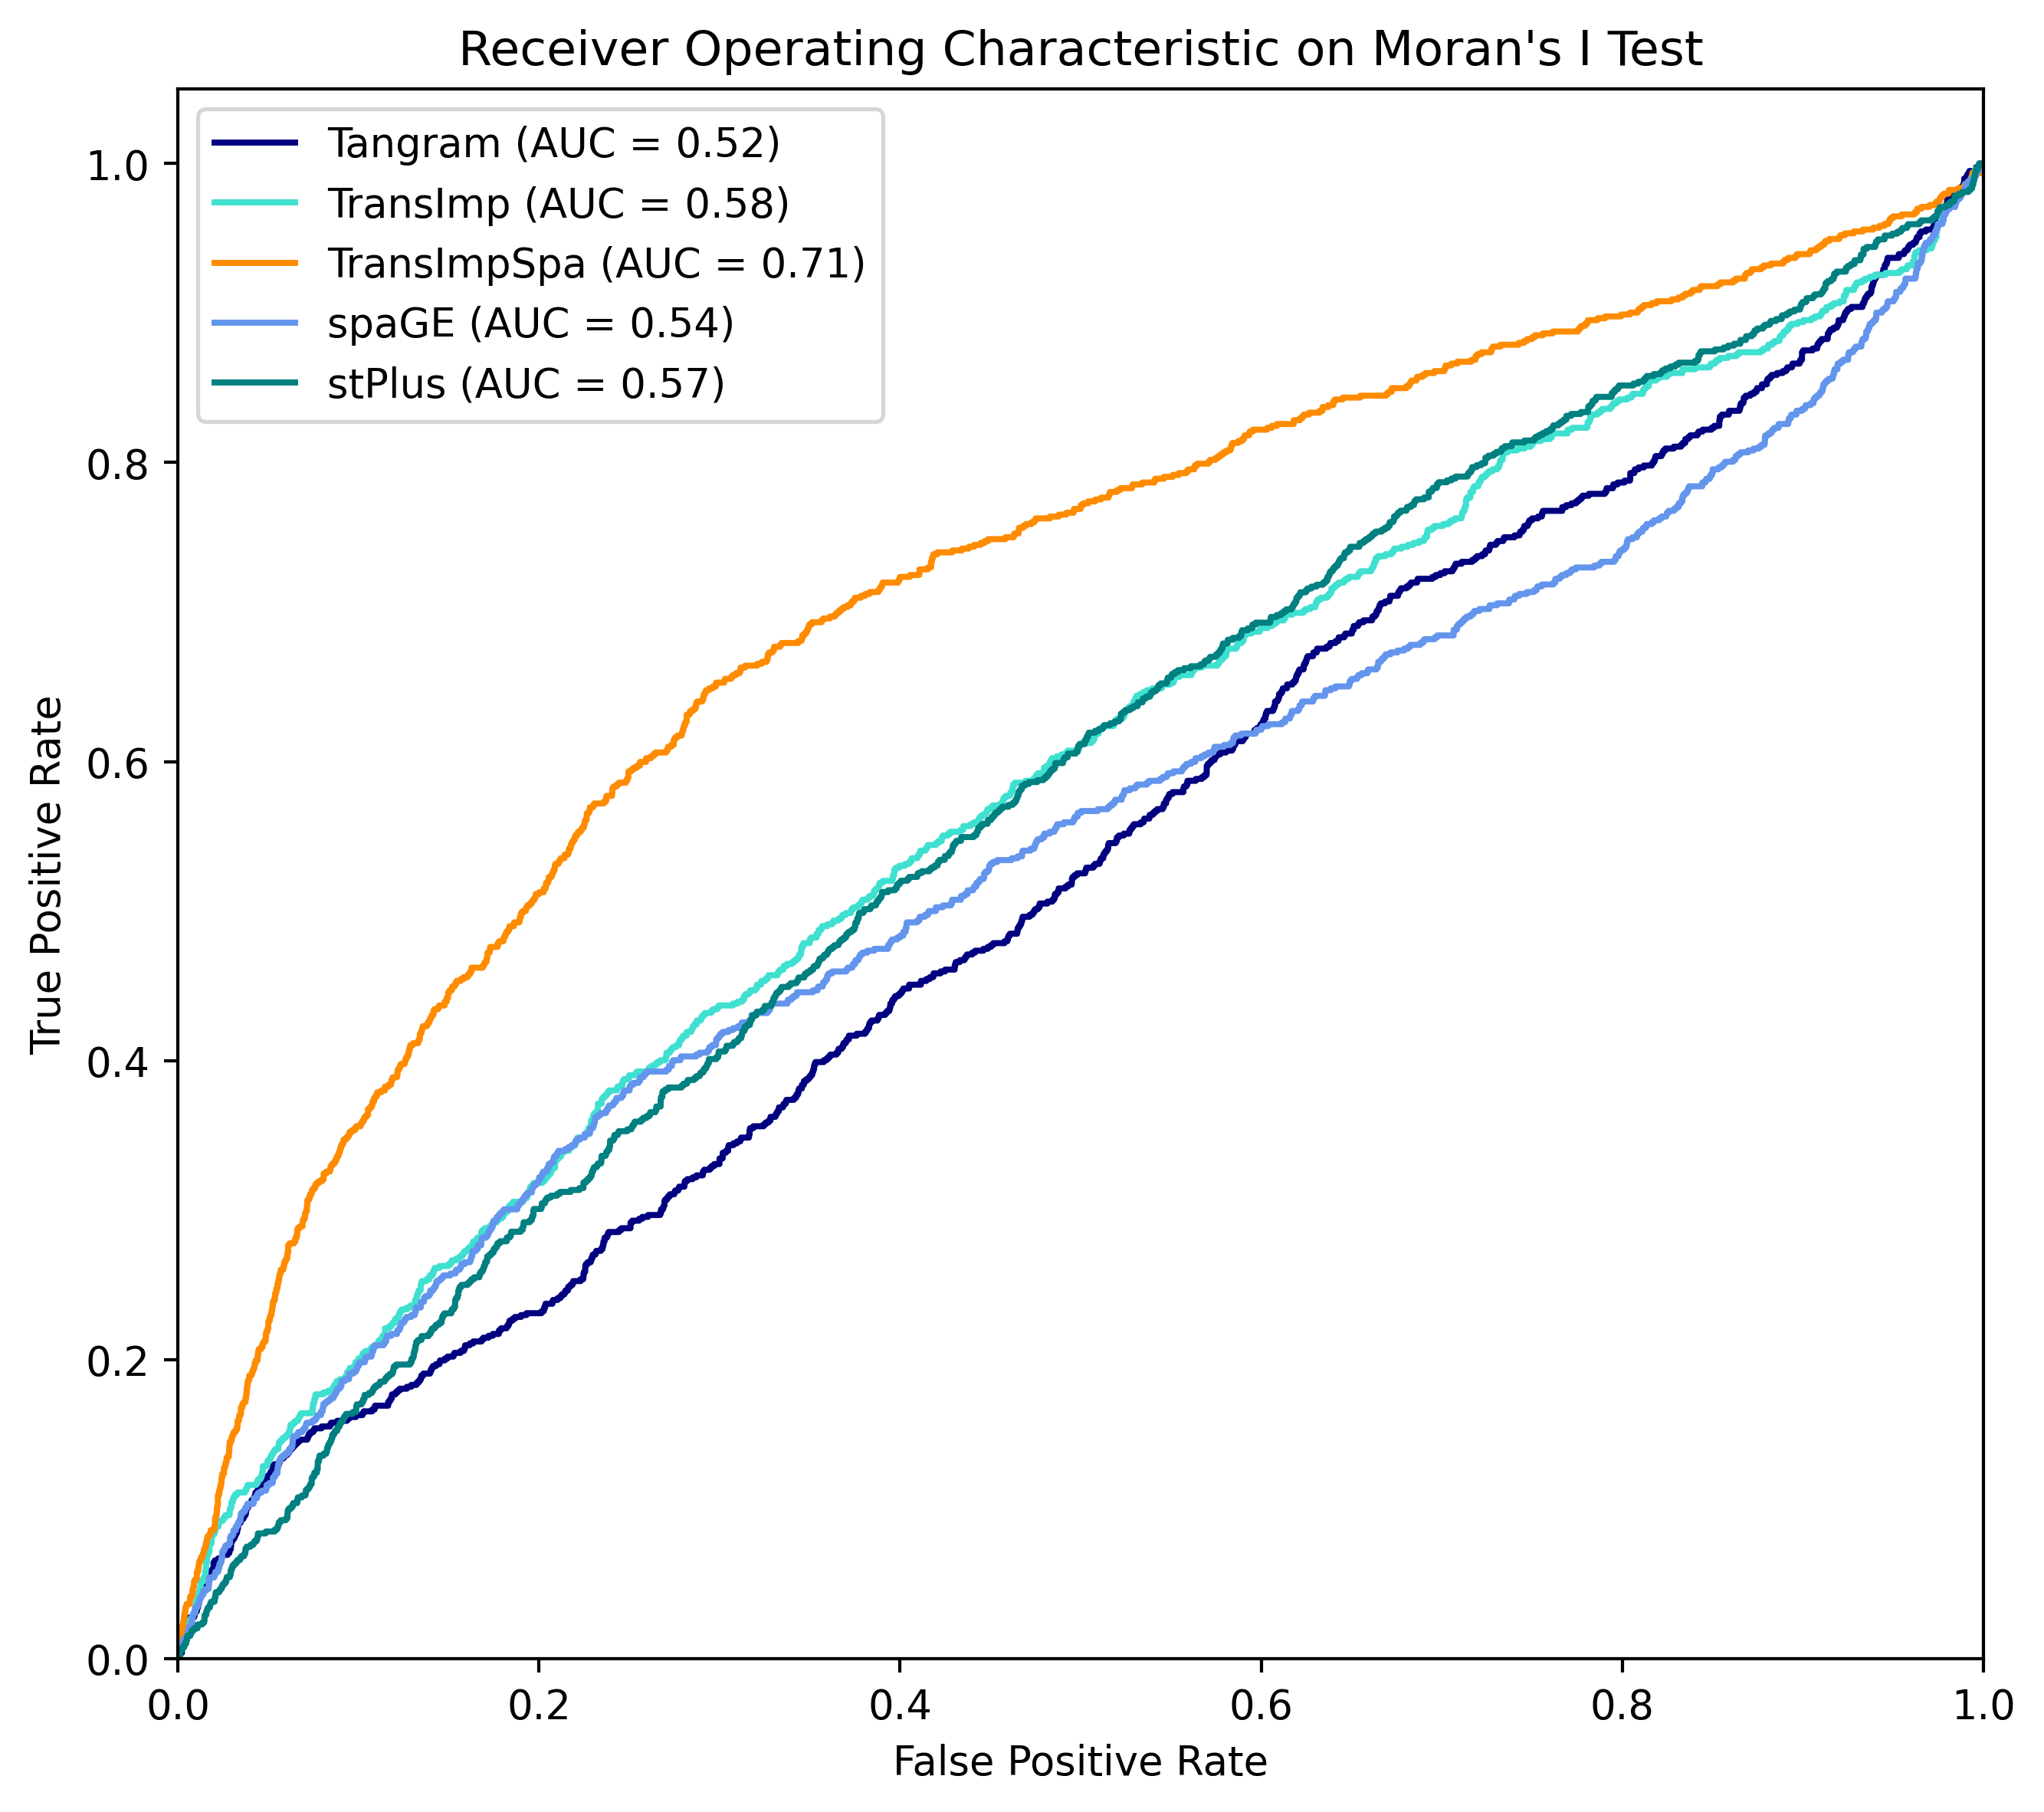

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [40]:
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min()/1e6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(method)
    preds = method_pval < thred
    
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    
    if not method in {"transImpCls", 'truth',  "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    
    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 7059/9758
Tangram
FPR: 0.990745
prec: 0.1127464989997142, recl: 0.9962121212121212,  F1: 0.20256739409499358
(TransImp) Valid genes: 7059/9758
TransImp
FPR: 0.996490
prec: 0.11242183058555998, recl: 0.9987373737373737,  F1: 0.20209504343382728
(TransImpSpa) Valid genes: 7059/9758
TransImpSpa
FPR: 0.035743
prec: 0.08943089430894309, recl: 0.027777777777777776,  F1: 0.04238921001926782
(spaGE) Valid genes: 7059/9758
spaGE
FPR: 0.933940
prec: 0.11519274376417234, recl: 0.9621212121212122,  F1: 0.2057513163223977
(stPlus) Valid genes: 7034/9758
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0
(TransImpCls) Valid genes: 7059/9758
TransImpCls
FPR: 0.997128
prec: 0.11235795454545454, recl: 0.9987373737373737,  F1: 0.20199182839632276
(TransImpClsSpa) Valid genes: 7059/9758
TransImpClsSpa
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0


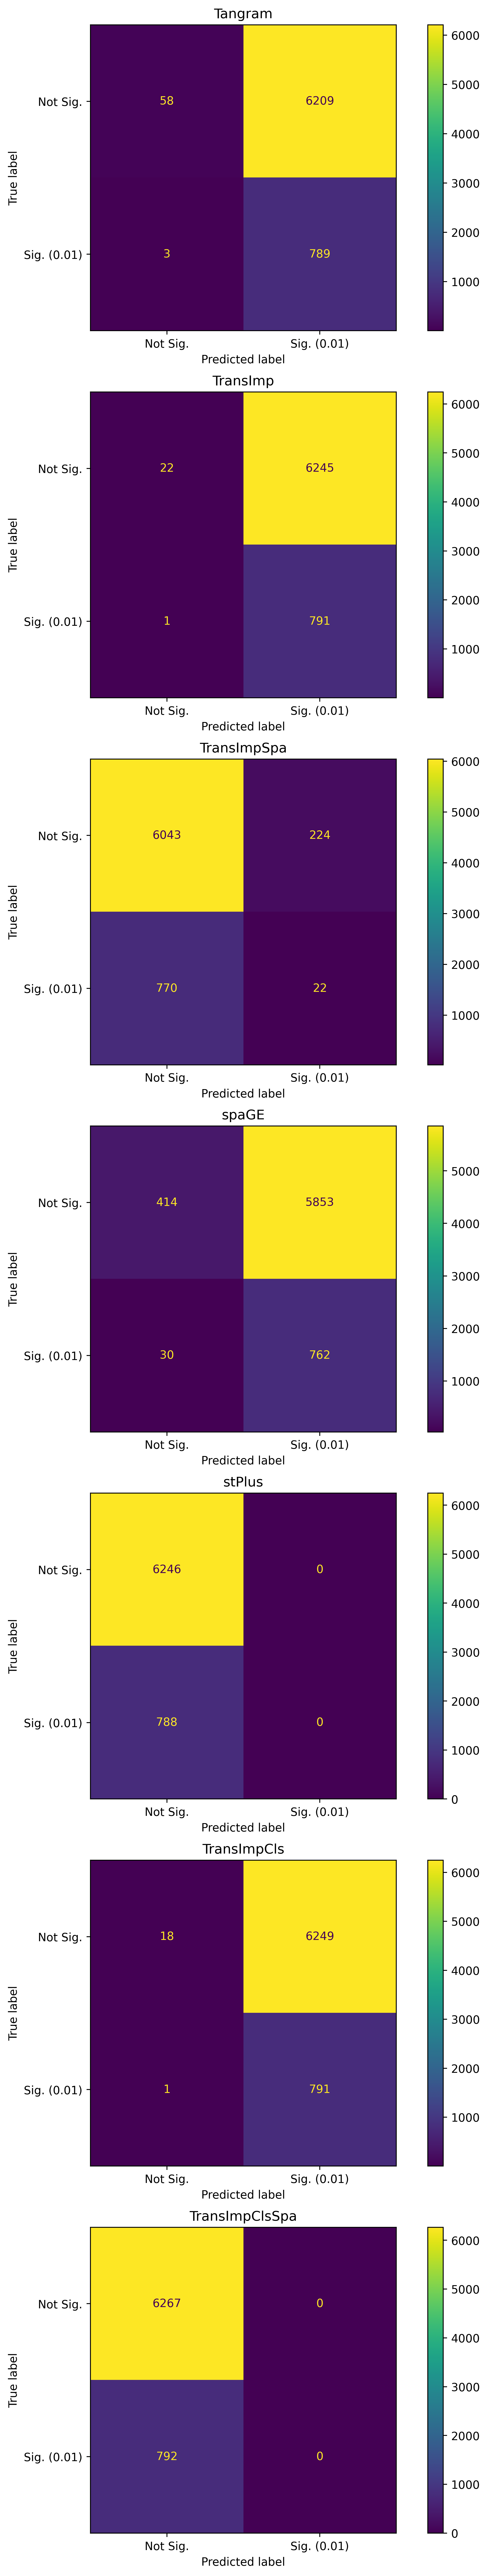

In [19]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in methods:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, pred_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    # score = df_I[method][sel]
    
    print(method)
    preds = pred_pval < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [20]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r melanoma5fold

[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 9758 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 9677 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With

In [21]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

truth
Tangram
TransImp
TransImpSpa
spaGE
stPlus
TransImpCls
TransImpClsSpa


(               truth       Tangram      TransImp   TransImpSpa         spaGE  \
 A1BG    1.214570e-01  9.405966e-26  2.219860e-21  2.100240e-09  7.498106e-23   
 A2M     1.366957e-10  7.161979e-28  7.620438e-26  1.343370e-14  1.476492e-21   
 A4GALT  3.096779e-01  1.776357e-15  1.090487e-18  1.671366e-08  1.995583e-02   
 AAAS    3.229083e-01  1.444841e-18  9.873417e-17  1.034213e-07  2.429809e-16   
 AACS    7.046077e-01  8.376522e-20  2.819966e-14  1.730740e-07  7.014389e-13   
 ...              ...           ...           ...           ...           ...   
 ZSWIM6  2.587926e-01  3.996981e-07  6.135765e-08  1.678859e-03  1.590690e-07   
 ZSWIM7  5.555882e-01  2.334533e-04  1.229539e-07  2.144661e-04  8.229825e-04   
 ZUFSP   9.318949e-01  2.221366e-08  1.671233e-07  6.272258e-04  5.874737e-07   
 ZWINT   3.388101e-01  3.330669e-15  1.152881e-18  1.416409e-10  3.939240e-06   
 ZYX     9.255968e-01  1.241721e-07  1.182196e-06  1.156516e-04  2.483801e-05   
 
               stPlus   Tr

(Tangram) Valid genes: 9758/9758
Tangram
FPR: 0.961588
(TransImp) Valid genes: 9758/9758
TransImp
FPR: 0.985489
(TransImpSpa) Valid genes: 9758/9758
TransImpSpa
FPR: 0.730260
(spaGE) Valid genes: 9758/9758
spaGE
FPR: 0.830986
(stPlus) Valid genes: 9758/9758
stPlus
FPR: 0.933525


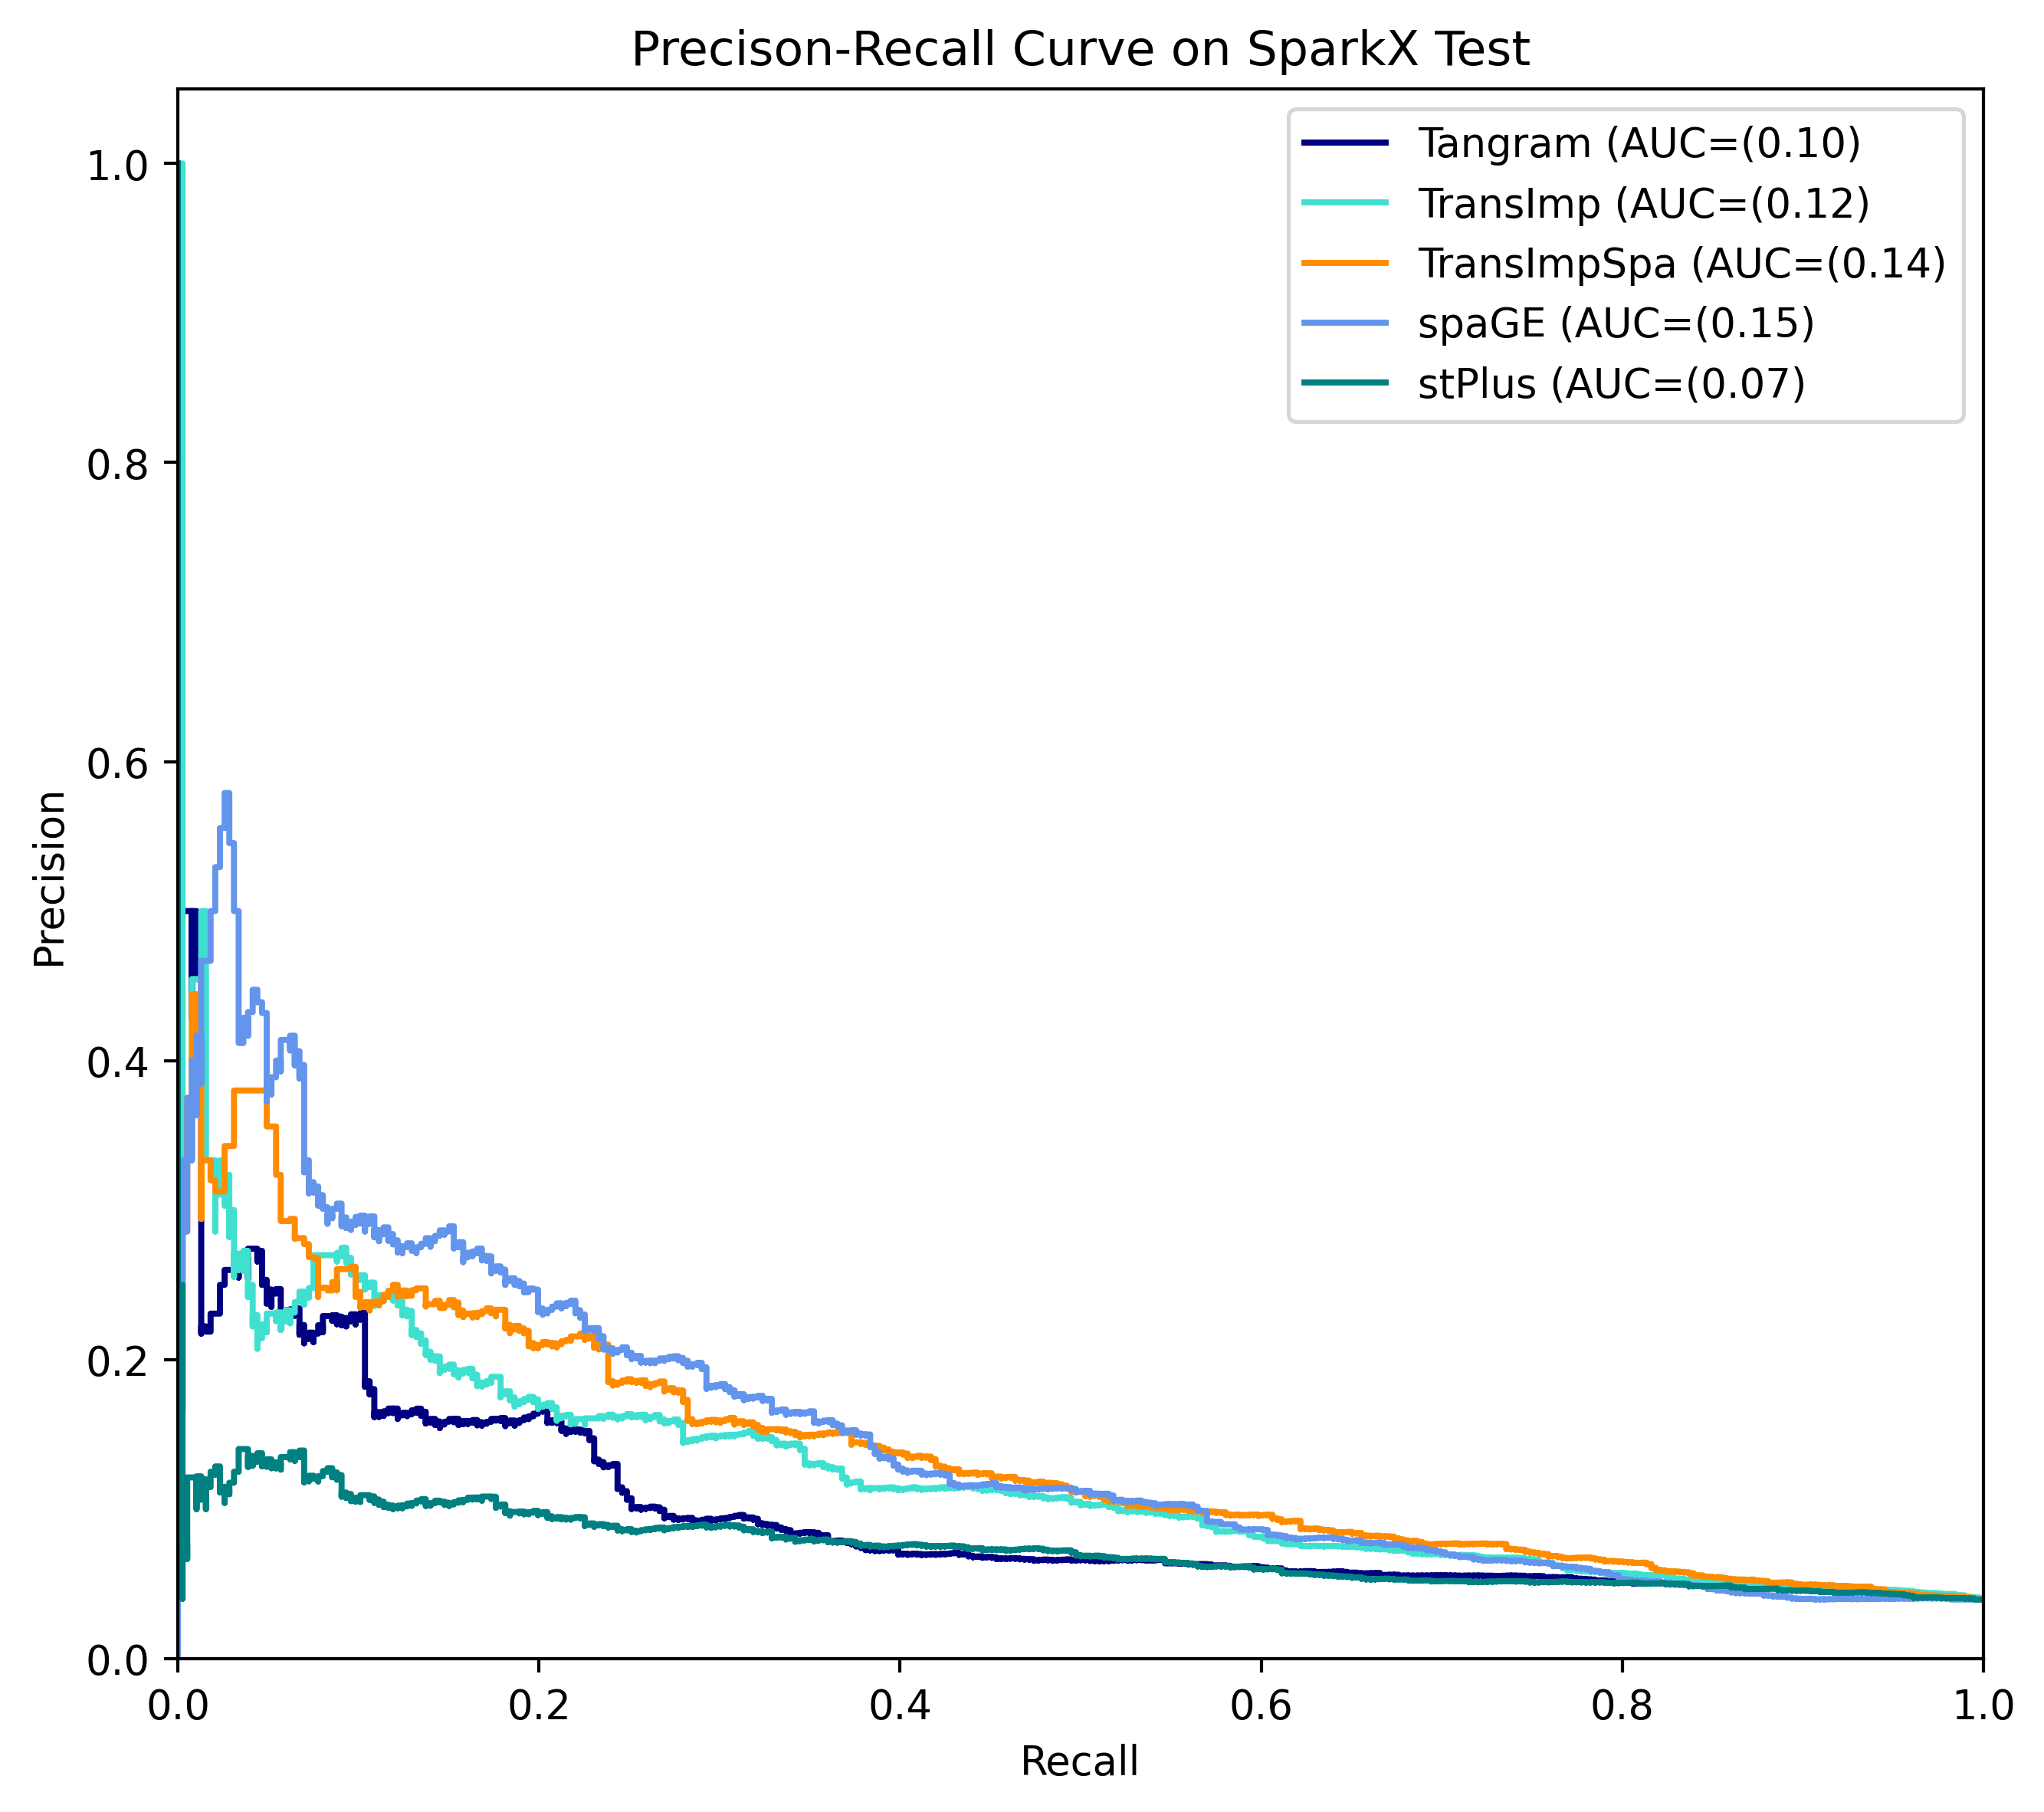

In [31]:
from sklearn import metrics
from matplotlib import pyplot as plt

thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
    
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
       
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 9758/9758
Tangram
FPR: 0.961588
(TransImp) Valid genes: 9758/9758
TransImp
FPR: 0.985489
(TransImpSpa) Valid genes: 9758/9758
TransImpSpa
FPR: 0.730260
(spaGE) Valid genes: 9758/9758
spaGE
FPR: 0.830986
(stPlus) Valid genes: 9758/9758
stPlus
FPR: 0.933525


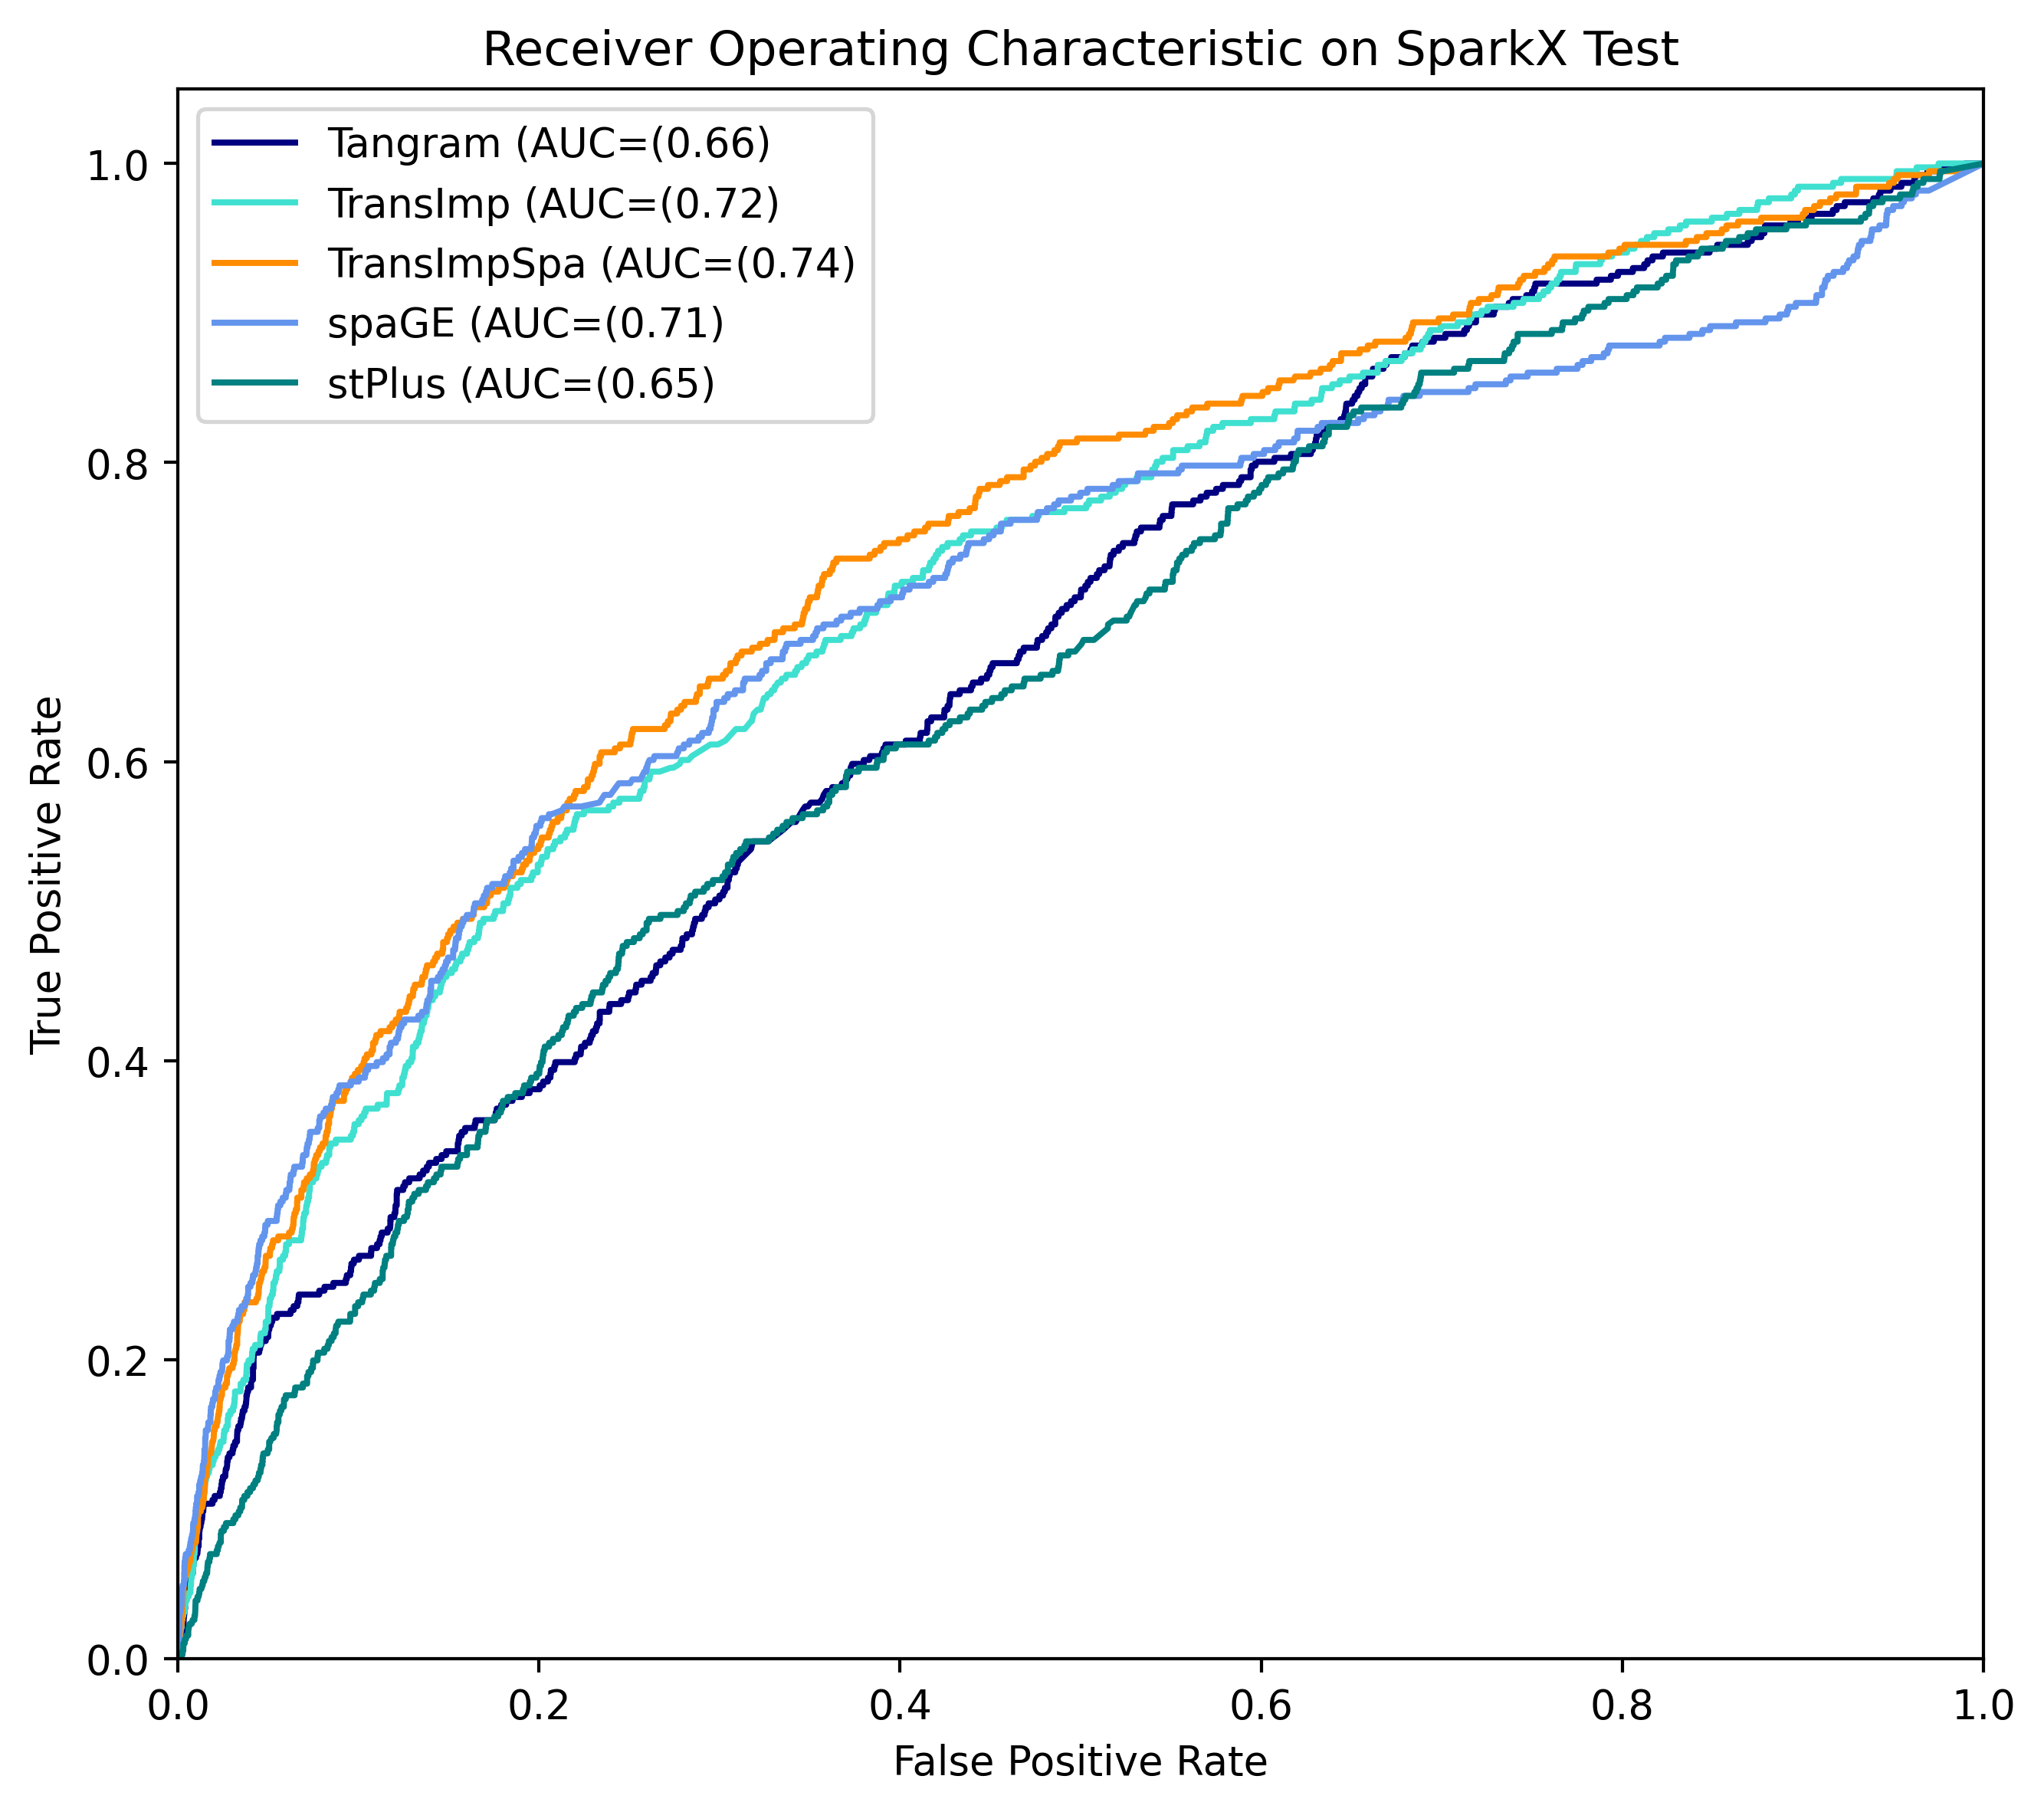

In [32]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 9758/9758
Tangram
FPR: 0.961588
prec: 0.04056212072820185, recl: 0.9870466321243523,  F1: 0.07792207792207793
(TransImp) Valid genes: 9758/9758
TransImp
FPR: 0.985489
prec: 0.040116399916857205, recl: 1.0,  F1: 0.0771382893685052
(TransImpCls) Valid genes: 9758/9758
TransImpCls
FPR: 0.987516
prec: 0.03993775933609958, recl: 0.9974093264248705,  F1: 0.07680031917015759
(TransImpClsSpa) Valid genes: 9758/9758
TransImpClsSpa
FPR: 0.812100
prec: 0.04360392058306107, recl: 0.8989637305699482,  F1: 0.08317353787152444
(TransImpSpa) Valid genes: 9758/9758
TransImpSpa
FPR: 0.730260
prec: 0.048916064480266815, recl: 0.9119170984455959,  F1: 0.09285149037193352
(spaGE) Valid genes: 9758/9758
spaGE
FPR: 0.830986
prec: 0.04194857916102842, recl: 0.883419689119171,  F1: 0.08009395184967705
(stPlus) Valid genes: 9758/9758
stPlus
FPR: 0.933525
prec: 0.04078500164455652, recl: 0.9637305699481865,  F1: 0.07825812559166931


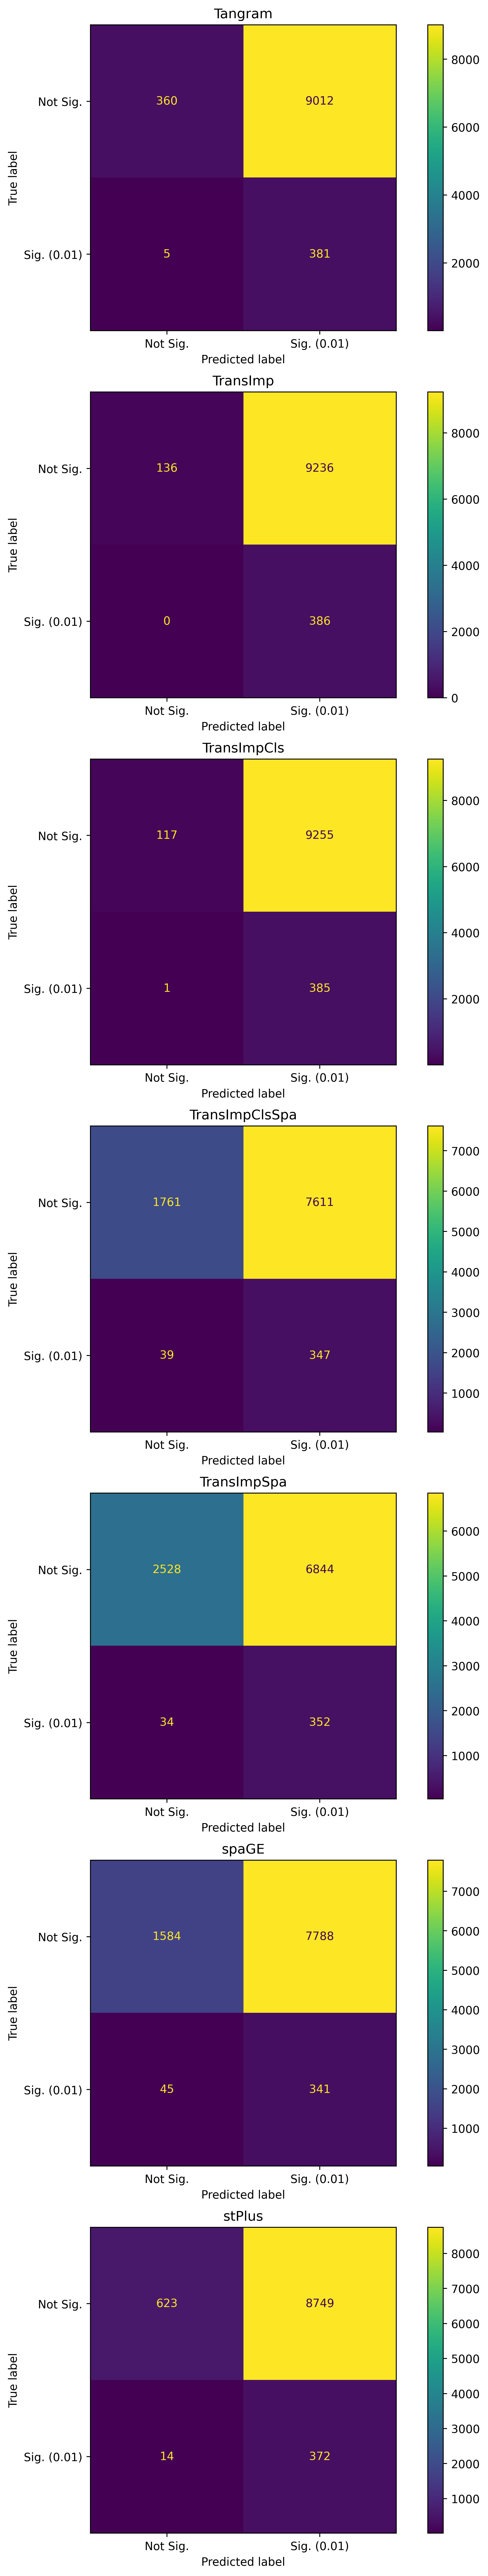

In [24]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [25]:
from scipy import sparse
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
def read_data(imp_adatas):
    spa_adata = sc.read_h5ad("../../data/ST/melanoma/spatial.h5ad")
    spa_adata = spa_adata[:, (spa_adata.var_names.values != 'MARCH1') & (spa_adata.var_names.values != 'MARCH2')].copy()
    adatas = {}
    for method in methods:
        adatas[method] = merge_data(imp_adatas[method], spa_adata)
        adatas[method].obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    return adatas

m_adatas = read_data(dict_adata)

Valid genes: 6388, Ex genes: 9758
Valid genes: 6388, Ex genes: 9758
Valid genes: 6388, Ex genes: 9758
Valid genes: 6388, Ex genes: 9758
Valid genes: 6388, Ex genes: 9758
Valid genes: 6388, Ex genes: 9758
Valid genes: 6388, Ex genes: 9758
Valid genes: 6388, Ex genes: 9758


In [26]:
def spatialdm(adata, spec, l):
    sdm.weight_matrix(adata,  n_nearest_neighbors=4, l=l, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=0)
    # global Moran selection
    # print(adata.uns)
    # print(adata)
    cp_adata = None
    try:
        sdm.spatialdm_global(adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)        
    except Exception as e:
        # print(e)
        cp_adata = adata.copy()
        sdm.extract_lr(cp_adata, spec, min_cell=1)
        sdm.spatialdm_global(cp_adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(cp_adata, method='z-score', fdr=True, threshold=0.1)
    # select significant pairs
    if not cp_adata is None:
        full_set = adata.uns['geneInter'].interaction_name
        # print(np.intersect1d(full_set, cp_adata.uns['global_res'].index.values))
        full_global_res = cp_adata.uns['global_res'].copy()
        full_global_res['global_I'] = cp_adata.uns['global_I'].copy()
        for pair in full_set:
            if pair not in cp_adata.uns['global_res'].index.values:
                # z	perm_pval	fdr	selected
                full_global_res = pd.concat([full_global_res, pd.DataFrame({
                    "Ligand0":{pair:pair.split("_")[0]},
                    "Receptor0":{pair:pair.split("_")[1]},
                    "Receptor1":{pair:None},
                    "z_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "z":{pair:np.random.rand()*0.01},
                    "perm_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "fdr":{pair:0.99 + np.random.rand() * 0.01},
                    "selected":{pair:False},
                    "global_I":{pair:np.random.rand() * 1e-6},
                })])
        # print(np.intersect1d(full_global_res.index, cp_adata.uns['global_res'].index.values))        
        adata.uns['global_res'] = full_global_res.loc[adata.uns['geneInter'].interaction_name].copy()
        adata.uns['global_I'] = full_global_res.global_I.values
        
        
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    print(adata.uns['global_res'].shape)
for md in m_adatas:
    spatialdm(m_adatas[md], "human", 1.2)    

100%|██████████| 10/10 [00:00<00:00, 258.58it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 265.29it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 259.66it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 212.08it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 265.17it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 266.51it/s]


1180 1180
(1160, 12)


100%|██████████| 10/10 [00:00<00:00, 280.72it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 267.56it/s]

1180 1180
(1160, 11)


In [27]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(m_adatas, outfile)

Tangram # 567 pairs, # sig pairs: (Truth): 142, (Preds) 381
TransImp # 567 pairs, # sig pairs: (Truth): 142, (Preds) 424
TransImpSpa # 567 pairs, # sig pairs: (Truth): 142, (Preds) 436
spaGE # 567 pairs, # sig pairs: (Truth): 142, (Preds) 367
stPlus # 567 pairs, # sig pairs: (Truth): 142, (Preds) 289
TransImpCls # 567 pairs, # sig pairs: (Truth): 142, (Preds) 356
TransImpClsSpa # 567 pairs, # sig pairs: (Truth): 142, (Preds) 401


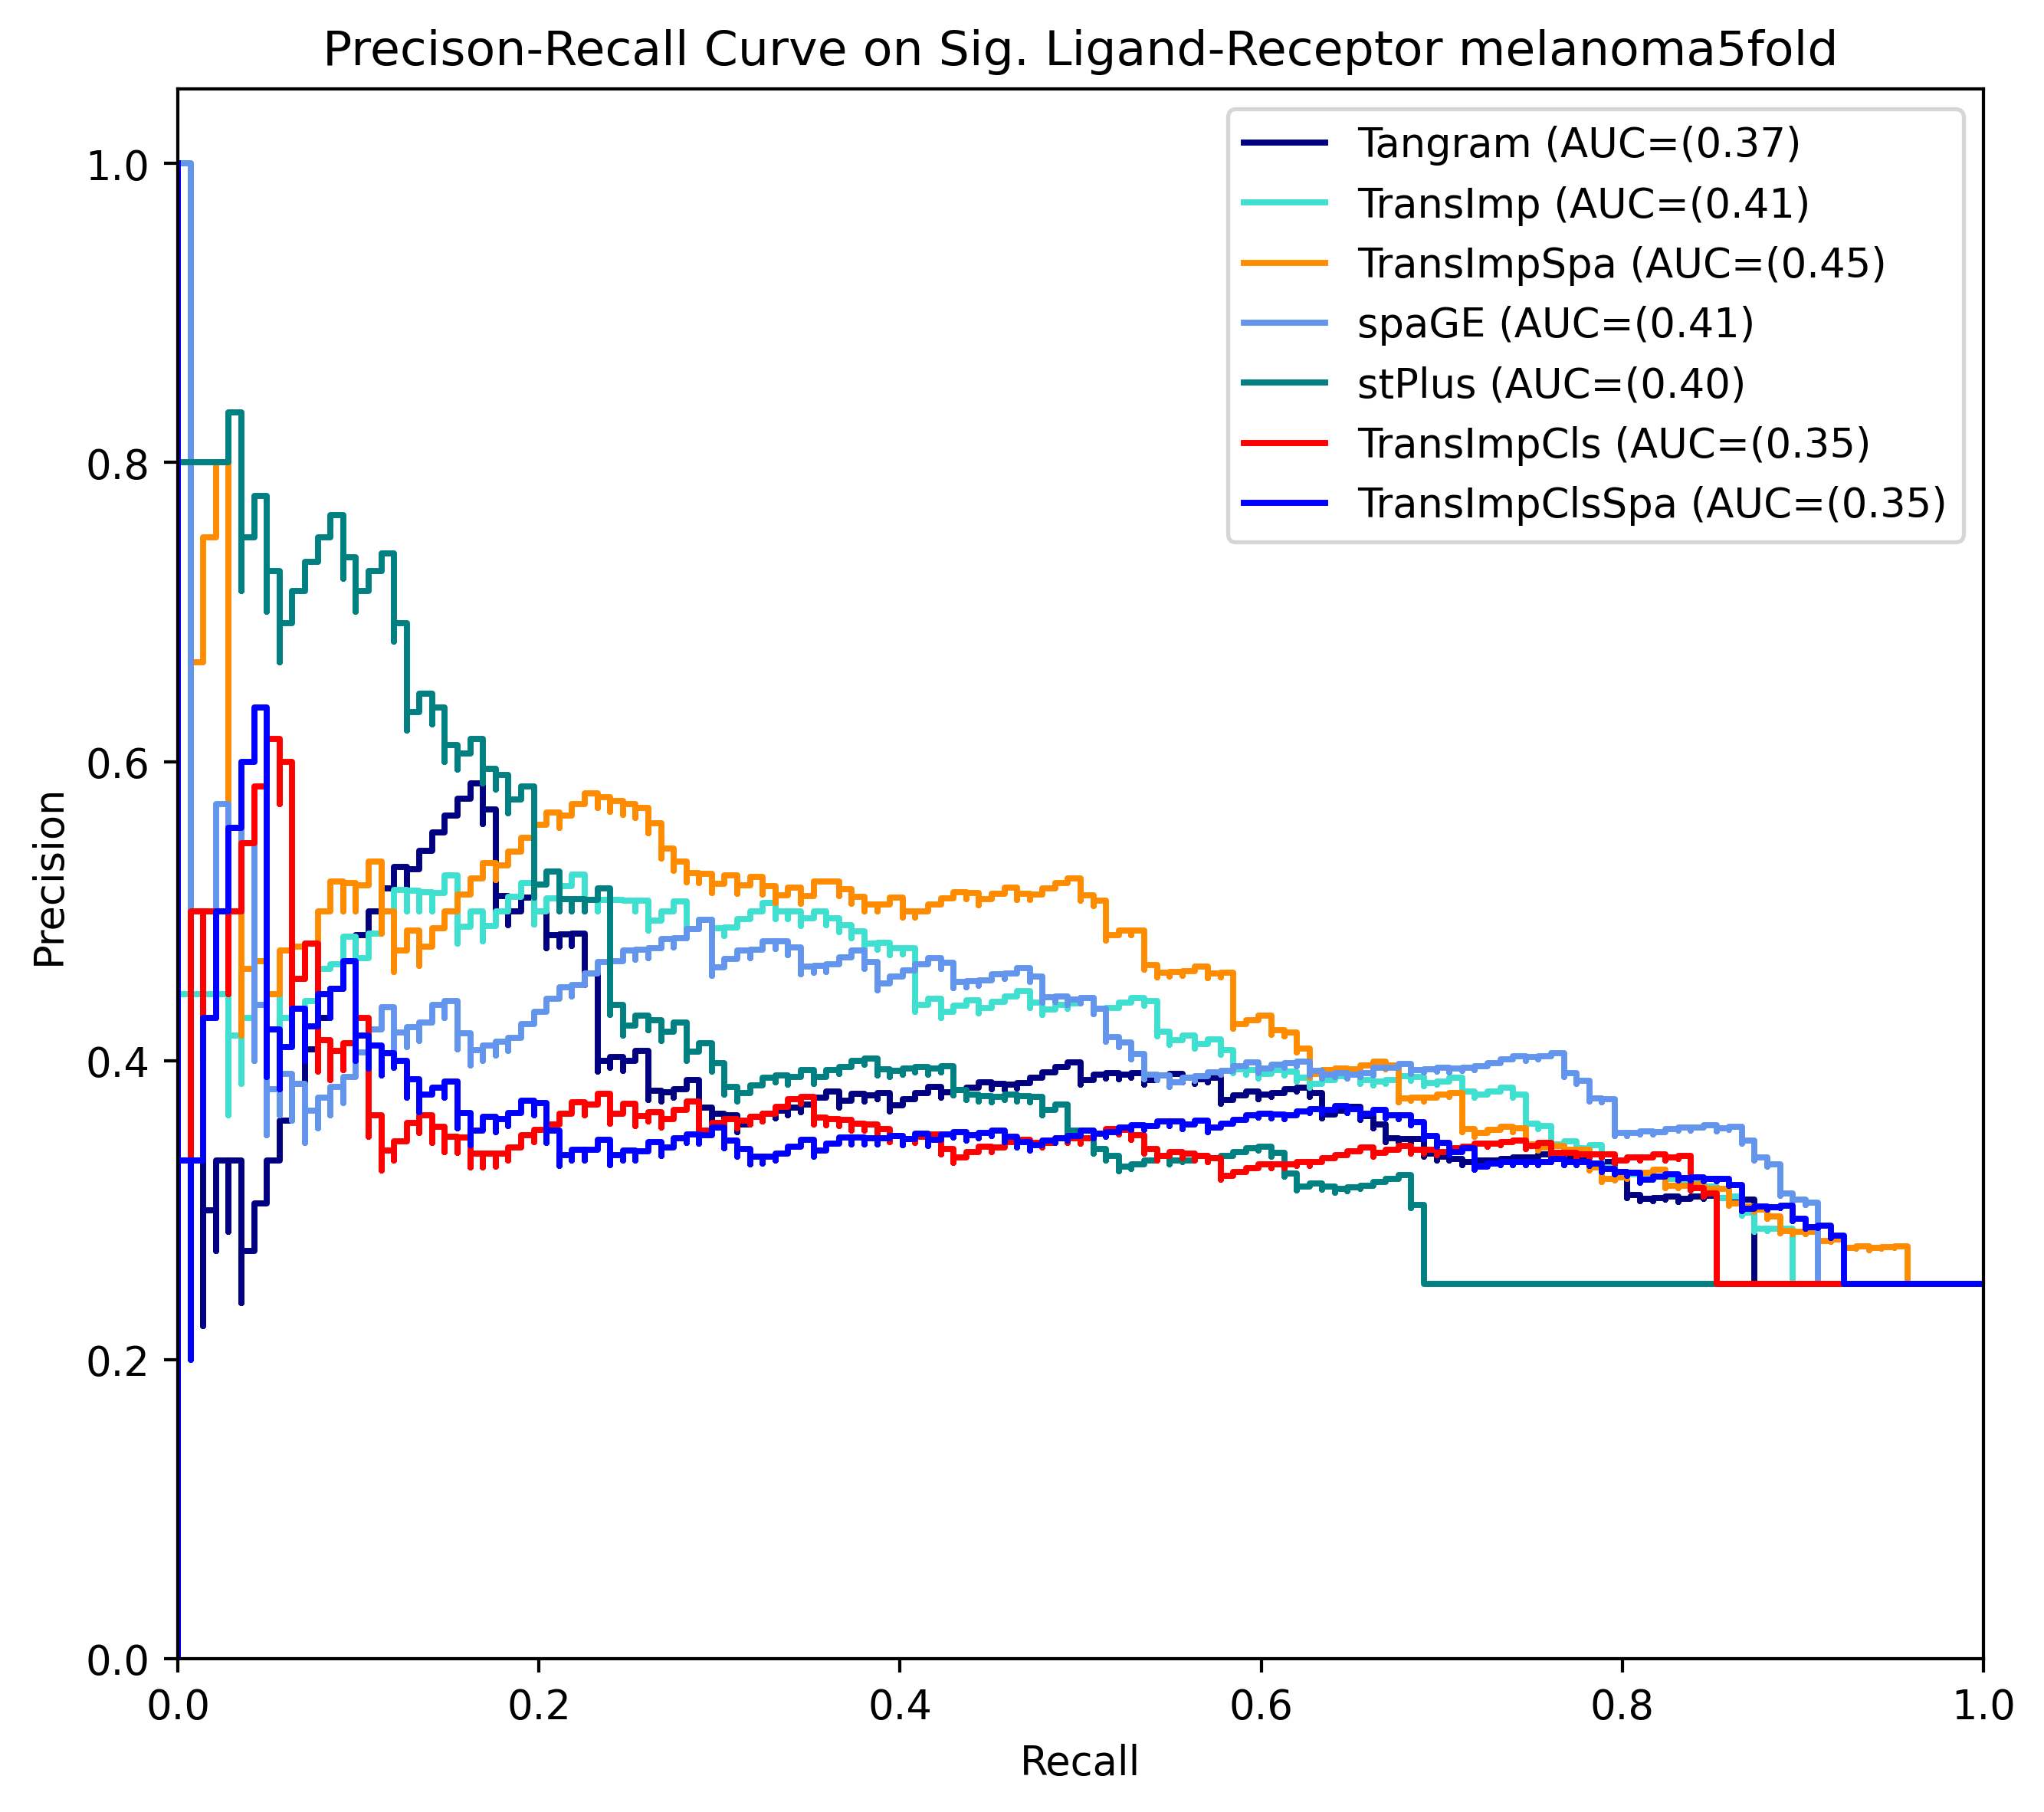

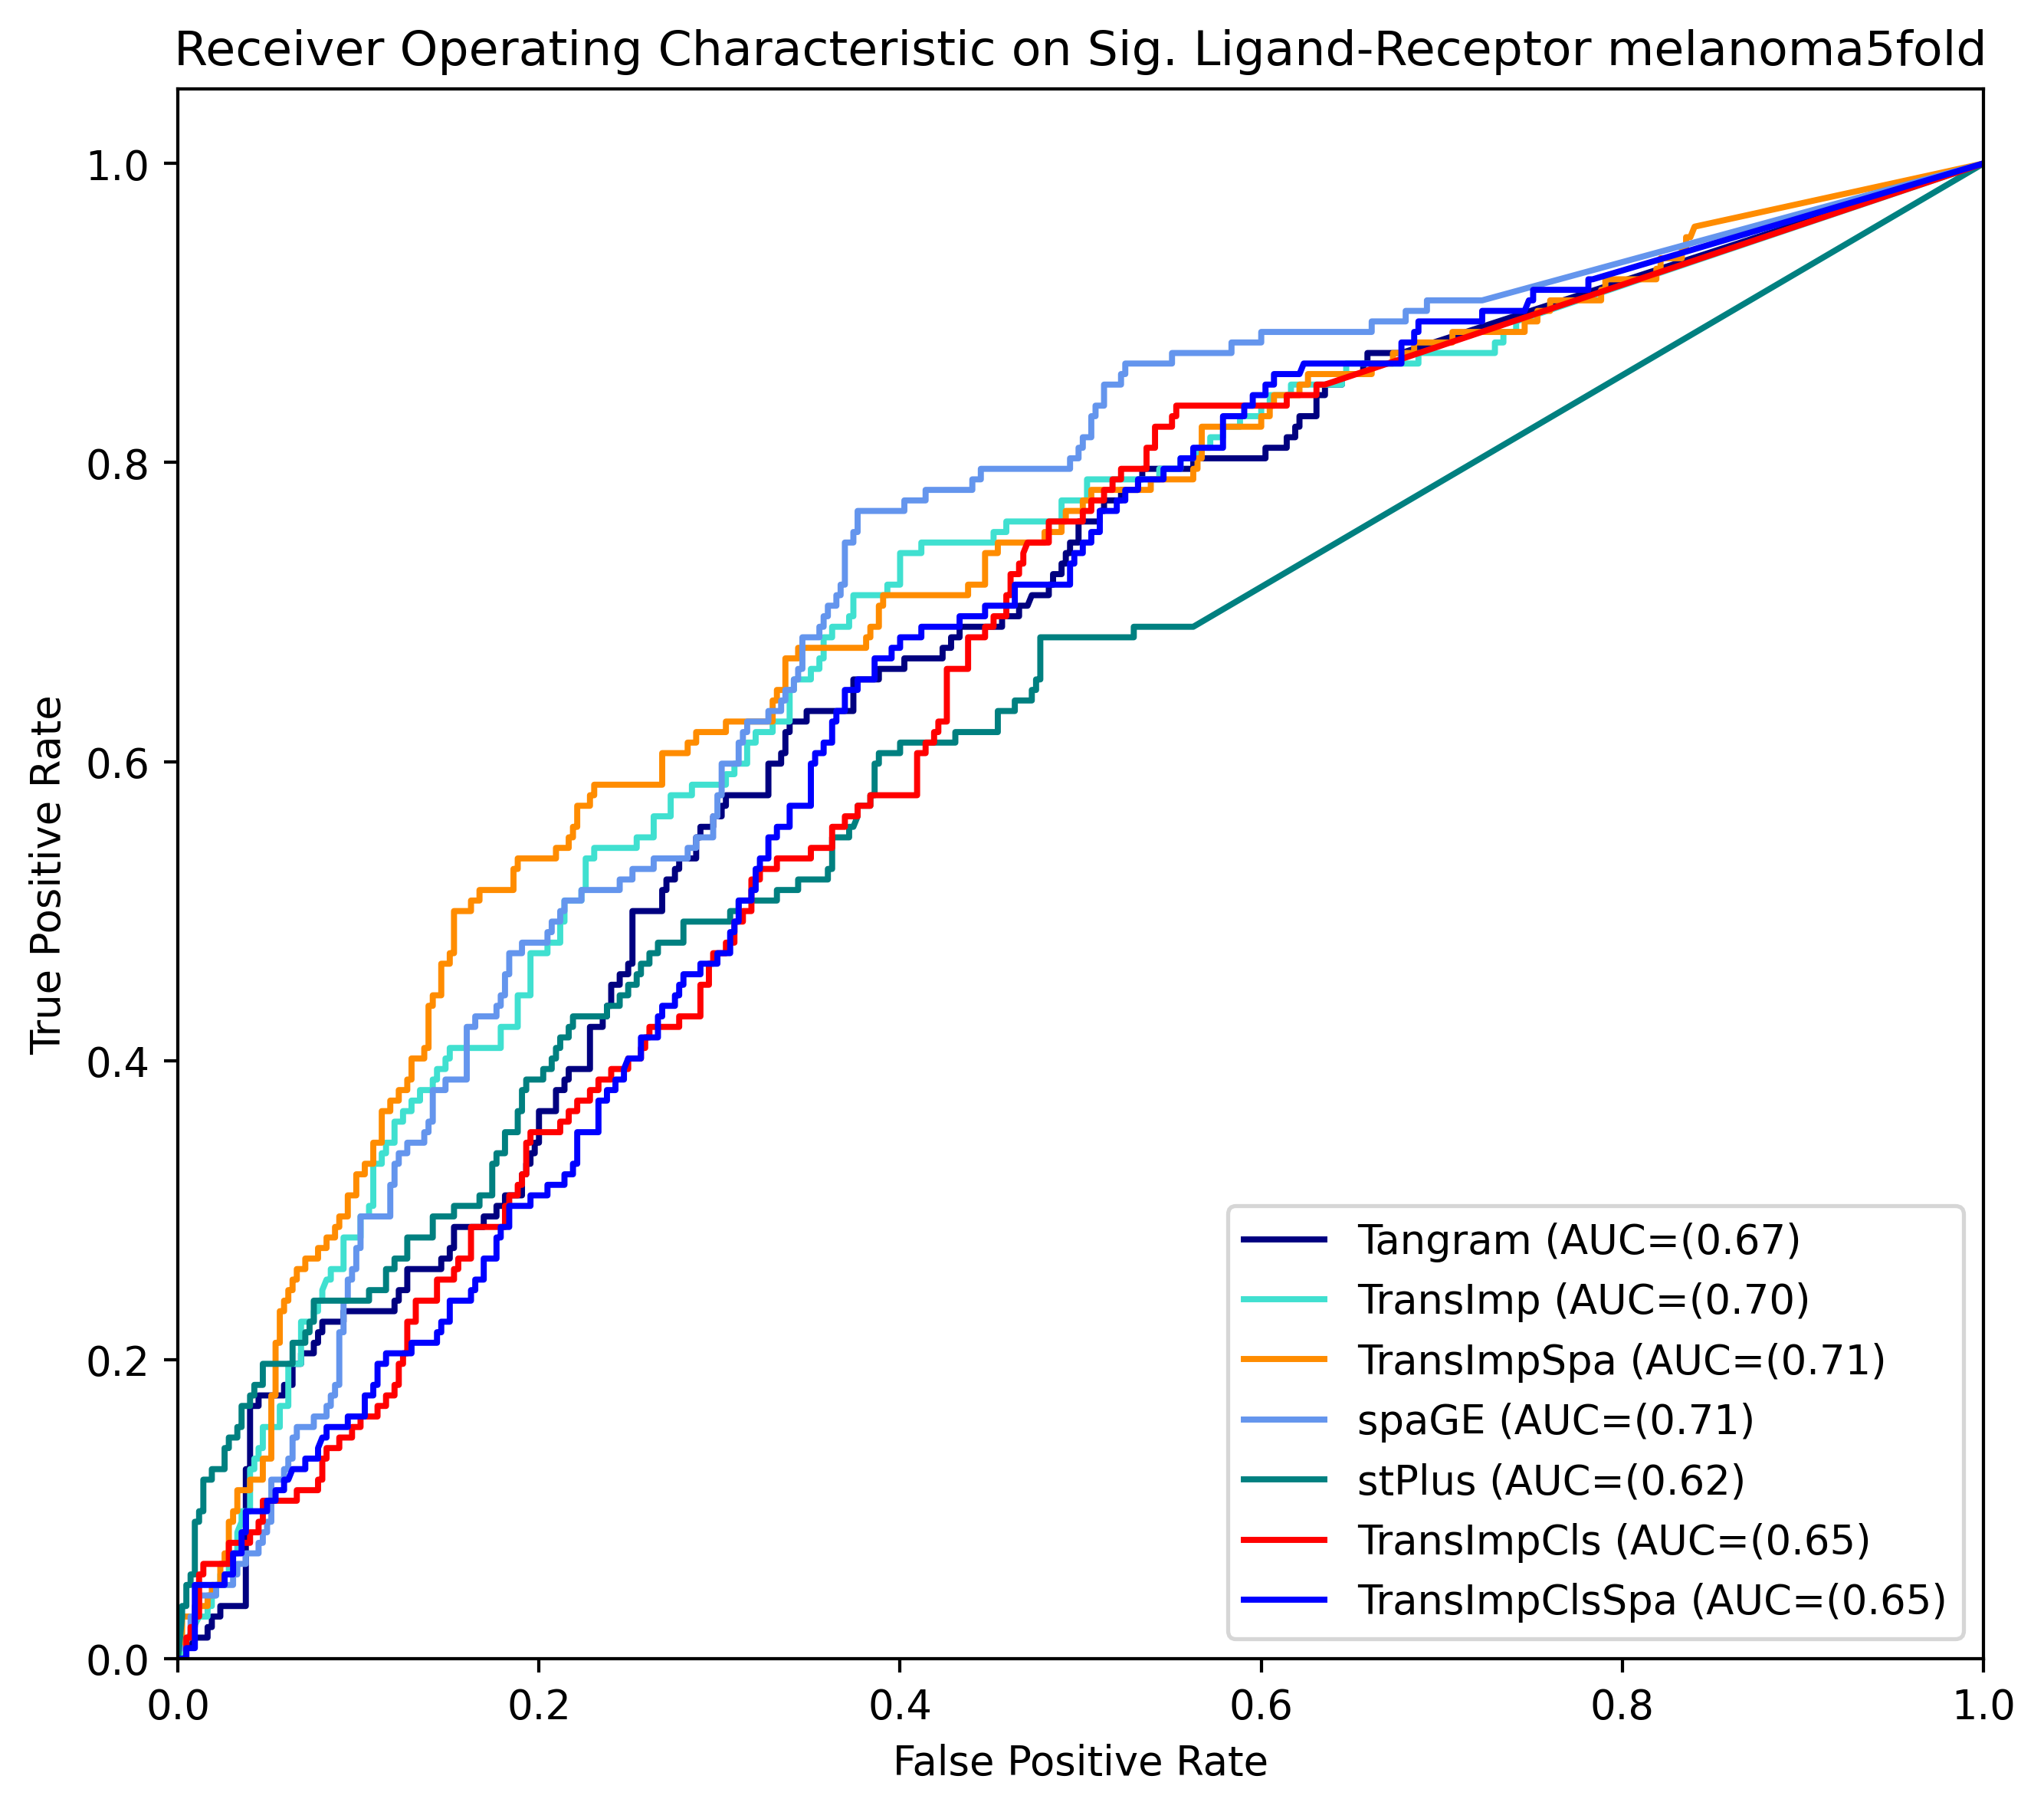

In [35]:
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        print(f"{md} # {len(genes)} pairs, # sig pairs: (Truth): {truth_res.loc[genes].selected.values.sum()}, (Preds) {adatas[md].uns['global_res'].loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(adatas[md].uns['global_res'].loc[genes].fdr.values)
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # plt.hist(score, bins=100);plt.show()
        # score = expit(score)
        # plt.hist(score, bins=100)
        # plt.show()
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # score = expit(score)
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    

precision_recall_curve(m_adatas, ST_name)
roc_curve(m_adatas, ST_name)
